#Group members
Nasrin Abharian

Farida Farpoor

# Build and Deploy Deep Learning Vision Models with TensorFlow 

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm


%matplotlib inline

# Load Dataset


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


## Reshaping Image Data for Modeling



In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


## Visualize sample images

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


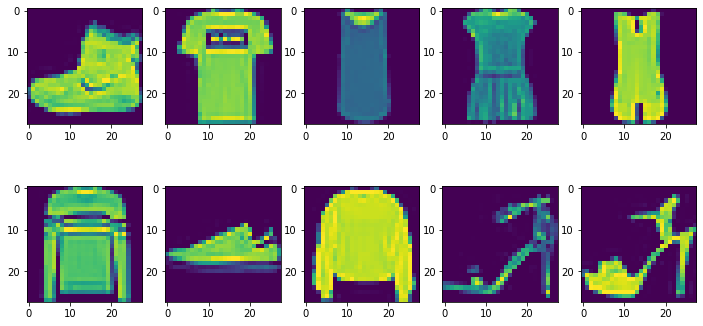

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax[0, 0].imshow(train_images_gr[0].reshape(28,28))
ax[0, 1].imshow(train_images_gr[1].reshape(28,28))
ax[0, 2].imshow(train_images_gr[2].reshape(28,28))
ax[0, 3].imshow(train_images_gr[3].reshape(28,28))
ax[0, 4].imshow(train_images_gr[4].reshape(28,28))
ax[1, 0].imshow(train_images_gr[5].reshape(28,28))
ax[1, 1].imshow(train_images_gr[6].reshape(28,28))
ax[1, 2].imshow(train_images_gr[7].reshape(28,28))
ax[1, 3].imshow(train_images_gr[8].reshape(28,28))
ax[1, 4].imshow(train_images_gr[9].reshape(28,28))

print([class_names[i] for i in train_labels[:10]])

# Fine-tuning a pre-trained ResNet-50 CNN Model





## Build CNN Model Architecture


In [5]:
pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 7.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [6]:
INPUT_SHAPE_RN = (32, 32, 3)

def create_cnn_architecture_model2(input_shape):
    inc_net = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', 
                                                          input_shape=input_shape)
    inc_net.trainable = True
    # Fine-tune the layers
    for layer in inc_net.layers:
        layer.trainable = False
    
    base_inc = inc_net
    base_out = base_inc.output
    pool_out = keras.layers.Flatten()(base_out)
    
    hidden1 = keras.layers.Dense(512, activation='relu')(pool_out)
    drop1 = keras.layers.Dropout(rate=0.3)(hidden1)
    hidden2 = keras.layers.Dense(512, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(rate=0.3)(hidden2)

    out = keras.layers.Dense(10, activation='softmax')(drop2)

    model = keras.Model(inputs=base_inc.input, outputs=out)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [7]:
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
          

## Reshaping Image Data for Modeling


In [8]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


## Resizing Image Data for Modeling


In [9]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [10]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 2.42 s, sys: 891 ms, total: 3.32 s
Wall time: 3.51 s


## Model Training


In [11]:
EPOCHS = 10
train_images_3ch_scaled = train_images_3ch / 255.
model2.fit(train_images_3ch_scaled, train_labels, validation_split=0.1, epochs=EPOCHS)

Epoch 1/10
1688/1688 [==============================] - 281s 164ms/step - loss: 1.1463 - accuracy: 0.5749 - val_loss: 0.7584 - val_accuracy: 0.7172
Epoch 2/10
1688/1688 [==============================] - 269s 159ms/step - loss: 0.7850 - accuracy: 0.7055 - val_loss: 0.7201 - val_accuracy: 0.7217
Epoch 3/10
1688/1688 [==============================] - 270s 160ms/step - loss: 0.7150 - accuracy: 0.7310 - val_loss: 0.6508 - val_accuracy: 0.7533
Epoch 4/10
1688/1688 [==============================] - 282s 167ms/step - loss: 0.6820 - accuracy: 0.7417 - val_loss: 0.6481 - val_accuracy: 0.7595
Epoch 5/10
1688/1688 [==============================] - 274s 162ms/step - loss: 0.6600 - accuracy: 0.7526 - val_loss: 0.6371 - val_accuracy: 0.7652
Epoch 6/10
1688/1688 [==============================] - 274s 162ms/step - loss: 0.6448 - accuracy: 0.7576 - val_loss: 0.5757 - val_accuracy: 0.7857
Epoch 7/10
1688/1688 [==============================] - 272s 161ms/step - loss: 0.6336 - accuracy: 0.7620 - val_

## Save Model Weights

In [12]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
    
model2.save_weights(filepath='model_weights/cnn_model2_wt.h5', overwrite=True)

## Build Model Architecture and Load Model Weights

In [13]:
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.load_weights('model_weights/cnn_model2_wt.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Evaluate Model Performance on Test Data

In [14]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model2.predict(test_images_3ch_scaled)
predictions[:5]

array([[1.56159203e-07, 8.32622007e-08, 1.85278797e-08, 1.92964558e-06,
        5.51401165e-08, 1.11650508e-02, 2.35476278e-07, 4.18129787e-02,
        6.68251014e-05, 9.46952701e-01],
       [4.25250977e-02, 1.26061759e-05, 8.43991995e-01, 4.85716946e-03,
        3.23239043e-02, 8.08458844e-06, 7.46369883e-02, 9.30092980e-08,
        1.64352357e-03, 5.52966242e-07],
       [4.71185544e-04, 9.98027027e-01, 1.35735600e-05, 1.29133952e-03,
        9.03093496e-06, 2.62468149e-07, 1.87302532e-04, 6.31427142e-08,
        2.29809658e-07, 5.12153520e-08],
       [7.38006609e-04, 8.63476157e-01, 1.02839505e-04, 1.33895919e-01,
        1.31148635e-03, 3.86316788e-06, 4.60038835e-04, 1.65724629e-07,
        6.66602455e-06, 4.73209229e-06],
       [1.27165705e-01, 1.43800062e-04, 7.06332475e-02, 3.10093351e-02,
        3.85705754e-02, 3.18985689e-03, 7.12172270e-01, 3.85272142e-04,
        1.54051185e-02, 1.32481207e-03]], dtype=float32)

In [15]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [19]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.71      0.81      0.76      1000
     Trouser       0.99      0.91      0.95      1000
    Pullover       0.67      0.66      0.66      1000
       Dress       0.75      0.86      0.80      1000
        Coat       0.78      0.43      0.56      1000
      Sandal       0.91      0.89      0.90      1000
       Shirt       0.44      0.53      0.48      1000
     Sneaker       0.87      0.87      0.87      1000
         Bag       0.93      0.93      0.93      1000
  Ankle boot       0.89      0.94      0.92      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,813,3,20,53,9,4,76,1,19,2
Trouser,5,911,2,63,3,0,15,0,1,0
Pullover,27,1,655,21,62,1,217,0,16,0
Dress,51,5,18,857,4,0,61,0,4,0
Coat,5,1,175,93,434,1,284,0,7,0
Sandal,0,0,0,0,0,891,1,79,1,28
Shirt,240,1,109,54,41,1,528,0,26,0
Sneaker,0,0,0,0,0,55,0,867,0,78
Bag,8,1,3,7,2,16,21,7,930,5
Ankle boot,0,0,1,0,0,10,0,47,0,942
